# Bayesian RKHS-based Functional Linear Regression with RJMCMC

## Imports and configuration

In [1335]:
# -- Libraries and notebook configuration

from itertools import product
from multiprocessing import Pool

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller
from eryn.ensemble import EnsembleSampler
from eryn.moves import CombineMove, GaussianMove, StretchMove
from eryn.prior import ProbDistContainer
from eryn.state import State
from rkbfr_jump import chain_utils, plot_utils, prediction, run_utils
from rkbfr_jump import simulation_utils as simulation
from rkbfr_jump.parameters import ThetaSpace, LogSqrtTransform
from rkbfr_jump import utility
from rkbfr_jump.likelihood import RKHSLikelihood
from rkbfr_jump.moves import GroupMoveRKHS, MTRJMoveRKHS, RJMoveRKHS
from rkbfr_jump.prior import RKHSPriorSimple, check_valid_t, generate_valid_t
from rkbfr_jump.update import AdjustStretchScaleCombineMove
from scipy.stats import invgamma
from scipy.stats import mode as mode_discrete
from scipy.stats import norm, trim_mean
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import (
    LinearSmootherGeneralizedCVScorer,
    SmoothingParameterSearch,
    akaike_information_criterion,
)
from skfda.representation import FDataGrid
from skfda.representation.basis import BSplineBasis, FourierBasis
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline

# Random seed for reproducibility
SEED = 2025
RNG = np.random.default_rng(SEED)
np.random.seed(SEED)

# Floating point precision for display
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 4)
pd.set_option("styler.format.precision", 4)

# Plots config
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [6, 4]
plt.style.use("arviz-darkgrid")
COLORS = ["darkgreen", "blue", "orange", "purple"]

# Extensions
%load_ext autoreload
%load_ext watermark
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Dataset

In [1336]:
# -- Dataset configuration

# Data generation process
SYNTHETIC_DATA = True
REGRESSOR_GEN = "GP"  # 'GP' or 'GBM'
MODEL_GEN = "L2"  # 'L2' or 'RKHS'
REAL_DATA = "Moisture"  # 'Moisture', 'Tecator' or 'Sugar'
INITIAL_SMOOTHING = False

# Dataset parameters for simulations
n_grid = 100
n_samples = 300
train_frac = 2/3
tau_range = (0, 1)

# Regressor parameters
mean_vector = np.zeros(n_grid)
kernel_fn = simulation.brownian_kernel
smoothing_params = np.logspace(-2, 2, 50)

# Response parameters
beta_coef_true = simulation.cholaquidis_scenario3  # True coefficient function for L2 model
beta_true = [-5., 5., 10.]  # True components for RKHS model
tau_true = [0.1, 0.6, 0.8]  # True time instants for RKHS model

In [1337]:
# -- Actual dataset generation

if SYNTHETIC_DATA and MODEL_GEN == "RKHS":  # Get y_noiseless
    x_fd, y, grid, y_noiseless = simulation.get_data_linear(
        SYNTHETIC_DATA,
        REGRESSOR_GEN,
        MODEL_GEN if SYNTHETIC_DATA else REAL_DATA,
        n_samples=n_samples,
        n_grid=n_grid,
        mean_vector=mean_vector,
        kernel_fn=kernel_fn,
        beta_tau_true=[beta_true, tau_true],
        initial_smoothing=INITIAL_SMOOTHING,
        smoothing_params=smoothing_params,
        tau_range=tau_range,
        return_y_noiseless=True,
        rng=RNG)
else:
    x_fd, y, grid = simulation.get_data_linear(
        SYNTHETIC_DATA,
        REGRESSOR_GEN,
        MODEL_GEN if SYNTHETIC_DATA else REAL_DATA,
        n_samples=n_samples,
        n_grid=n_grid,
        mean_vector=mean_vector,
        kernel_fn=kernel_fn,
        beta_coef_true=beta_coef_true,
        initial_smoothing=INITIAL_SMOOTHING,
        smoothing_params=smoothing_params,
        tau_range=tau_range,
        rng=RNG)

if not SYNTHETIC_DATA:  # Update parameters
    n_grid = len(grid)
    n_samples = len(x_fd)

# Train/test split
idx_samples = np.arange(n_samples)
X_fd, X_test_fd, Y, Y_test, idx_train, idx_test = train_test_split(
    x_fd, y, idx_samples, train_size=train_frac, random_state=SEED
)

if INITIAL_SMOOTHING:
    # Nadaraya-Watson kernel smoothing
    X_fd, X_test_fd = simulation.smooth_data(X_fd, X_test_fd, smoothing_params)

# We always assume that the regressors are centered
X_m = X_fd.mean(axis=0)
X_fd = X_fd - X_m
X_test_fd = X_test_fd - X_m

# Get data matrices
X = X_fd.data_matrix.reshape(-1, n_grid)
X_test = X_test_fd.data_matrix.reshape(-1, n_grid)

# Scale training data for our methods so that SD=1
X_std_orig = np.std(X, axis=0)
X_scaled = X / X_std_orig
Y_std_orig = np.std(Y)
Y_scaled = Y / Y_std_orig

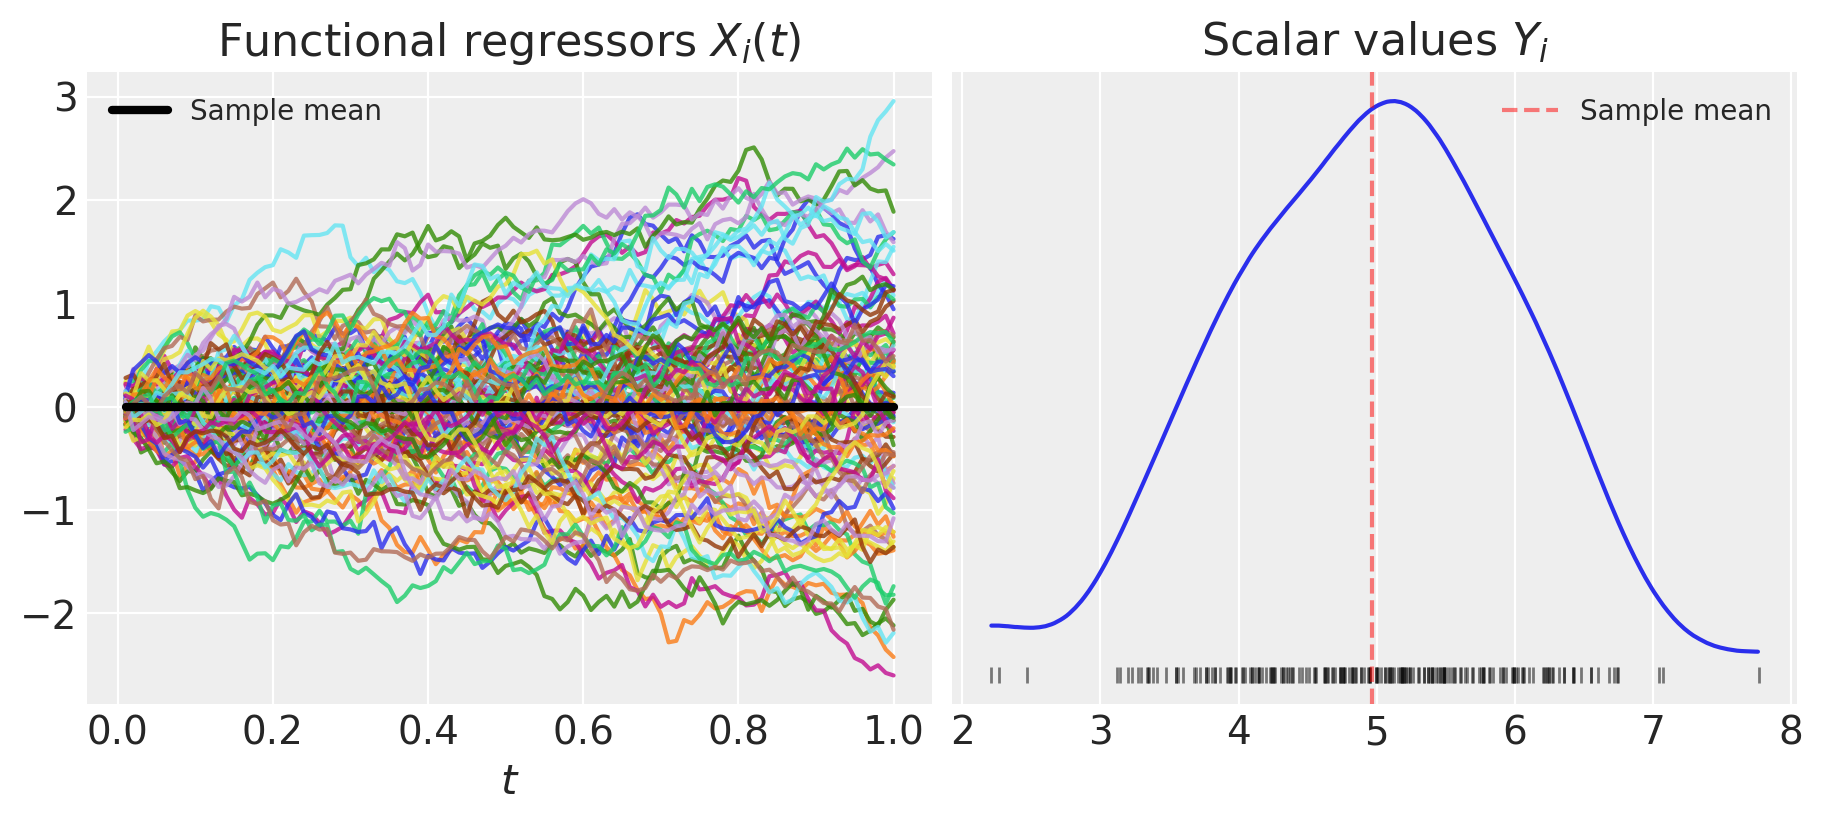

In [1338]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    grid,
    n_samples=n_samples//3,
)

## Bayesian model

In [1339]:
# -- Bayesian model parameters

TRANSFORM_SIGMA = True
RELABEL_STRATEGY = "auto"  # beta, tau or auto
THETA_SPACE = ThetaSpace(
    grid,
    names=["b", "t", "alpha0", "sigma2"],
    idx=[0, 1, 0, 1],
    transform_sigma=TRANSFORM_SIGMA,
)
SD_PRIOR_BETA = 5
MIN_DIST_TAU = 1
LAMBDA_P = 3

### Prior

In [1340]:
# -- Prior distributions

priors_simple = {
    "all_models_together": RKHSPriorSimple(
        THETA_SPACE,
        grid,
        sd_beta=SD_PRIOR_BETA,  # vague prior on beta; data is scaled to have SD=1
        lambda_p=LAMBDA_P,   # Only useful for the RJ move (not MT RJ)
        min_dist_tau=MIN_DIST_TAU,  # impose |t_i - t_j| > minimum_distance_tau
        transform_sigma=TRANSFORM_SIGMA,
    )
}

# Prior distribution in Eryn format (would not be possible if our prior was more complex)
priors_simple_eryn = {
    "components": ProbDistContainer(
        {
            THETA_SPACE.idx_beta: priors_simple["all_models_together"].prior_beta,
            THETA_SPACE.idx_tau: priors_simple["all_models_together"].prior_tau,
        }
    ),
    "common": ProbDistContainer(
        {
            (THETA_SPACE.idx_alpha0, THETA_SPACE.idx_sigma2): priors_simple["all_models_together"].prior_alpha0_sigma2,
        }
    ),
}

### Likelihood

In [1341]:
# -- Log-likelihood

ll = RKHSLikelihood(THETA_SPACE, grid, X_scaled, Y_scaled, transform_sigma=TRANSFORM_SIGMA)

## Sampler

### Initial values

In [1342]:
# -- Set reasonable initial values for all chains

# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 5

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components values (b) from prior
coords["components"][..., THETA_SPACE.idx_beta] = priors_simple_eryn["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"]), keys=[THETA_SPACE.idx_beta]
)[..., THETA_SPACE.idx_beta]

# uniform initial values for component times (t), but constricted to be different
coords["components"][..., THETA_SPACE.idx_tau] = generate_valid_t(
    (ntemps, nwalkers, nleaves_max["components"]), grid, MIN_DIST_TAU, shuffle=True
)
assert np.all(
    check_valid_t(
        THETA_SPACE.get_idx_tau_grid(coords["components"][..., THETA_SPACE.idx_tau]),
        min_dist=MIN_DIST_TAU,
    )
)

# sample initial values for alpha0 from normal distribution
coords["common"][:, :, 0, THETA_SPACE.idx_alpha0] = norm(
    0, 10 * np.abs(Y_scaled.mean())
).rvs(size=(ntemps, nwalkers))

# sample initial values for sigma2 from inverse-gamma distribution
sigma2_initial_values = invgamma(
    2, scale=(np.mean(np.abs(Y)) / 100) / Y_std_orig**2
).rvs(size=(ntemps, nwalkers))
coords["common"][:, :, 0, THETA_SPACE.idx_sigma2] = (
    LogSqrtTransform.forward(sigma2_initial_values)
    if TRANSFORM_SIGMA
    else sigma2_initial_values
)

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any walker,
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx_all_false = np.where(
    np.sum(inds["components"], axis=-1) == 0
)  # Find branches with 0 active components
inds["components"][*idx_all_false, 0] = True  # Set the first component to True

# set indices for the single leaf of [alpha0,sigma2]
# (always used because nleaves_min["common"]=nleaves_max["common"]=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

## Experiments

In [1343]:
# -- Set sampler parameters

USE_MT_RJ = False

# number of steps
nsteps = 500
thin_by = 1
burn = 2000

# number of cores
njobs = 4
vectorize = True

# moves
move_stretch = StretchMove(gibbs_sampling_setup="common", a=2)

# Gaussian move is only for testing purposes; unused in our model
factor = 0.00001
cov = {"common": np.diag(np.ones(ndims["common"])) * 0.00001}
move_gaussian = GaussianMove(cov, gibbs_sampling_setup="common")

# Sample all parameters leaf by leaf in the components branch (currently unused)
gibbs_sampling_setup_group = [
    (
        "components",
        np.zeros((nleaves_max["components"], ndims["components"]), dtype=bool),
    )
    for _ in range(nleaves_max["components"])
]
for i in range(nleaves_max["components"]):
    gibbs_sampling_setup_group[i][-1][i] = True

# IMPORTANT: moves, update and Likelihood objects must be re-created before sampling again
move_group = GroupMoveRKHS(
    THETA_SPACE,
    dist_measure="beta",
    nfriends=nwalkers,
    n_iter_update=100,
    gibbs_sampling_setup="components",  # gibbs_sampling_setup_group,
    a=2,
)

# rj moves
num_try = 2
rjmoveMTRKHS = MTRJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
    num_try=num_try,
)

rjmoveRKHS = RJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
)

# update function
update_fn_group = AdjustStretchScaleCombineMove(
    idx_moves=[0, 1],
    target_acceptance=0.3,
    max_factor=0.1,
    supression_factor=0.1,
    min_a=1.1,
)
update_iters = 50

# -- Posterior sampling with Eryn (RJMCMC)

# re-set random seed for reproducible sampling
np.random.seed(SEED)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors_simple,
        pool=pool if not vectorize else None,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=CombineMove([move_group, move_stretch]),
        rj_moves=rjmoveMTRKHS if USE_MT_RJ else rjmoveRKHS,
        update_fn=update_fn_group,
        update_iterations=update_iters,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print(f"Sampling posterior distribution (transform_sigma={TRANSFORM_SIGMA})...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

Sampling posterior distribution (transform_sigma=True)...


100%|██████████| 500/500 [00:04<00:00, 107.57it/s]


In [1344]:
# -- Post-process the cold chain only

# 1. Get full chain, with shape (nsteps, nwalkers, nleaves_max, ndim) and corresponding indices
(
    full_chain_components,
    full_chain_common,
    inds_components_post,
    inds_common_post,
    idx_order,
) = chain_utils.get_full_chain_at_T(
    ensemble,
    THETA_SPACE,
    X_std_orig,
    Y_std_orig,
    T=0,
    transform_sigma=TRANSFORM_SIGMA,
    relabel_strategy=RELABEL_STRATEGY,
)

# 2. Get flat chain, with shape (N, ndim), where N is the number of valid samples across all steps, walkers and leaves
flat_chain_components = chain_utils.get_flat_chain_components(
    full_chain_components, THETA_SPACE, ndims["components"]
)
flat_chain_common = full_chain_common.reshape(-1, 2)

# 3. Get values of leaves (number of components) accross the chain
nleaves_all_T = ensemble.get_nleaves()["components"]
nleaves = nleaves_all_T[:, 0, ...]  # T=0

# Print sampling information 
components_last = full_chain_components[-1, 0, :]  # last sample of first walker
common_last = full_chain_common[-1, 0, :]  # last sample of first walker
print("* Last sample (T=0, W=0):")
df_components = pd.DataFrame(
    {"$b$": components_last[:, THETA_SPACE.idx_beta], "$t$": components_last[:, THETA_SPACE.idx_tau]}
)
df_common = pd.DataFrame(
    {"$\\alpha_0$": [common_last[THETA_SPACE.idx_alpha0]], "$\\sigma^2$": [common_last[THETA_SPACE.idx_sigma2]]}
)
display(df_components)
display(df_common.style.hide(axis="index"))

print("\n* Acceptance % (T=0)")
print(
    f"[{ensemble.moves[0].moves[0].__class__.__name__}]",
    100 * ensemble.moves[0].acceptance_fraction_separate[0][0],
)
print(
    f"[{ensemble.moves[0].moves[1].__class__.__name__}]",
    100 * ensemble.moves[0].acceptance_fraction_separate[1][0],
)
print(
    f"[{ensemble.rj_moves[0].__class__.__name__}]",
    100 * ensemble.rj_acceptance_fraction[0],
)
print("\n* Temperature swaps accepted %:", 100 * ensemble.swap_acceptance_fraction)
print("\n* Last values of a (parameter of the in-model moves):")
print(f"[GroupMoveRKHS] a={ensemble.moves[0].moves[0].a:.2f}")
print(f"[StretchMove] a={ensemble.moves[0].moves[1].a:.2f}")

if nleaves_max["components"] > 1:
    print(f"\n* Chain ordered by: {'beta' if idx_order == THETA_SPACE.idx_beta else 'tau'}")

print("\n* ", end="")
_ = ensemble.backend.get_gelman_rubin_convergence_diagnostic(thin=thin_by)

* Last sample (T=0, W=0):


$b$     $t$
0  0.6726  0.2552
1  0.1682  0.4974
2  0.5692  0.7649
3     NaN     NaN
4     NaN     NaN


* Acceptance % (T=0)
[GroupMoveRKHS] [14.24 15.76 14.68 14.6  15.24 13.76 14.72 15.24 16.32 13.4  14.68 14.16
 15.6  15.88 14.12 15.28 14.72 13.72 14.2  14.52 14.68 13.84 14.   14.36
 14.52 13.76 14.56 13.24 14.88 13.68 14.32 14.48]
[StretchMove] [66.68 66.48 66.76 68.84 69.68 68.12 67.16 66.72 67.   68.84 68.36 67.28
 68.28 68.2  68.24 69.04 68.24 66.56 68.28 67.48 68.36 68.76 68.24 66.64
 67.96 66.92 68.52 69.2  68.92 67.32 68.64 67.24]
[RJMoveRKHS] [1.2 1.4 0.8 0.4 1.2 1.4 0.8 0.8 1.4 1.8 0.8 0.4 1.6 0.8 0.8 1.  1.2 1.
 1.8 1.  0.4 1.8 1.8 0.8 1.2 1.  1.4 1.  1.  1.2 1.4 0.8]

* Temperature swaps accepted %: [18.0312 17.4375 18.5437 16.9187]

* Last values of a (parameter of the in-model moves):
[GroupMoveRKHS] a=1.16
[StretchMove] a=4.72

* Chain ordered by: tau

* Gelman-Rubin diagnostic (should be near 1) 
  <R̂>: Mean value for all parameters

  --------------
 Model: components
   T 	 <R̂>
  --------------
   0	1.00
   1	1.00
   2	1.00
   3	1.00
   4	1.01


 Model: common
   T

## Analysis

**TODO**: more plots with marginal posterior distributions, e.g. after conditioning on MAP p (traceplot with all components together for beta and tau). Also, try some sort of "triangular plot", where the rows are the values of p (from 1 to nleaves_max) and the columns are the distributions of beta|p, if applicable.

**TODO**: posterior pp plots

### Flat posterior distributions (for all p)

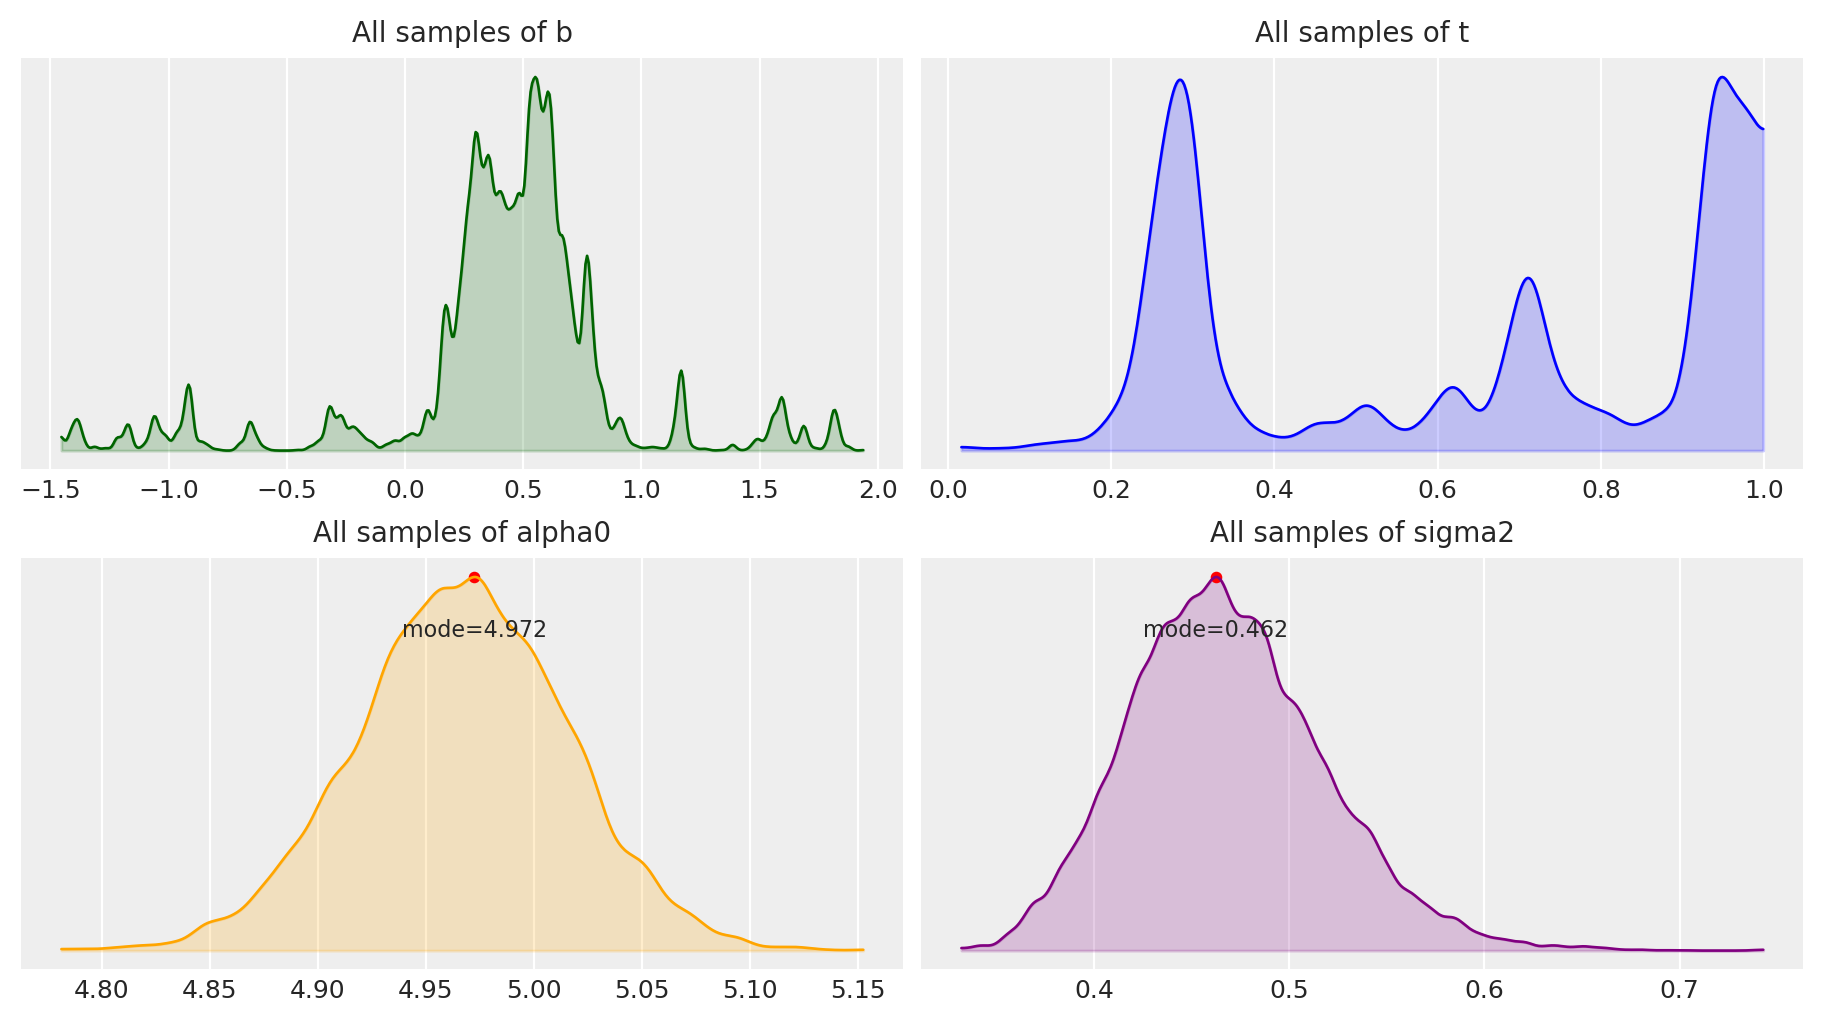

In [1345]:
fig, axs = plt.subplots(2, 2, figsize=(9, 5))

samples_vars = [
    flat_chain_components[:, THETA_SPACE.idx_beta],
    flat_chain_components[:, THETA_SPACE.idx_tau],
    flat_chain_common[:, THETA_SPACE.idx_alpha0],
    flat_chain_common[:, THETA_SPACE.idx_sigma2],
]
if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
    ref_values = [
        beta_true,
        tau_true,
        Y.mean(),
        np.var(y[idx_train] - y_noiseless[idx_train]),
    ]

for i, (var, samples, color) in enumerate(zip(THETA_SPACE.names, samples_vars, COLORS)):
    ax = axs[i // 2, i % 2]

    # Set title and ticks
    ax.set_title(f"All samples of {var}", fontsize=10)
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_yticklabels([])  # Hide y-axis labels

    # Plot dist and reference values
    az.plot_dist(samples, ax=ax, color=color, fill_kwargs={"alpha": 0.2}, textsize=9)
    if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
        plot_utils.plot_reference_values(
            ref_values[i],
            ax,
            label=f"Train {var}",
            color=color,
            legend_kwargs={"fontsize": 8},
        )

    if i // 2 > 0:
        plot_utils.plot_mode(samples, ax)

### Trace plot for individual components (for all p)

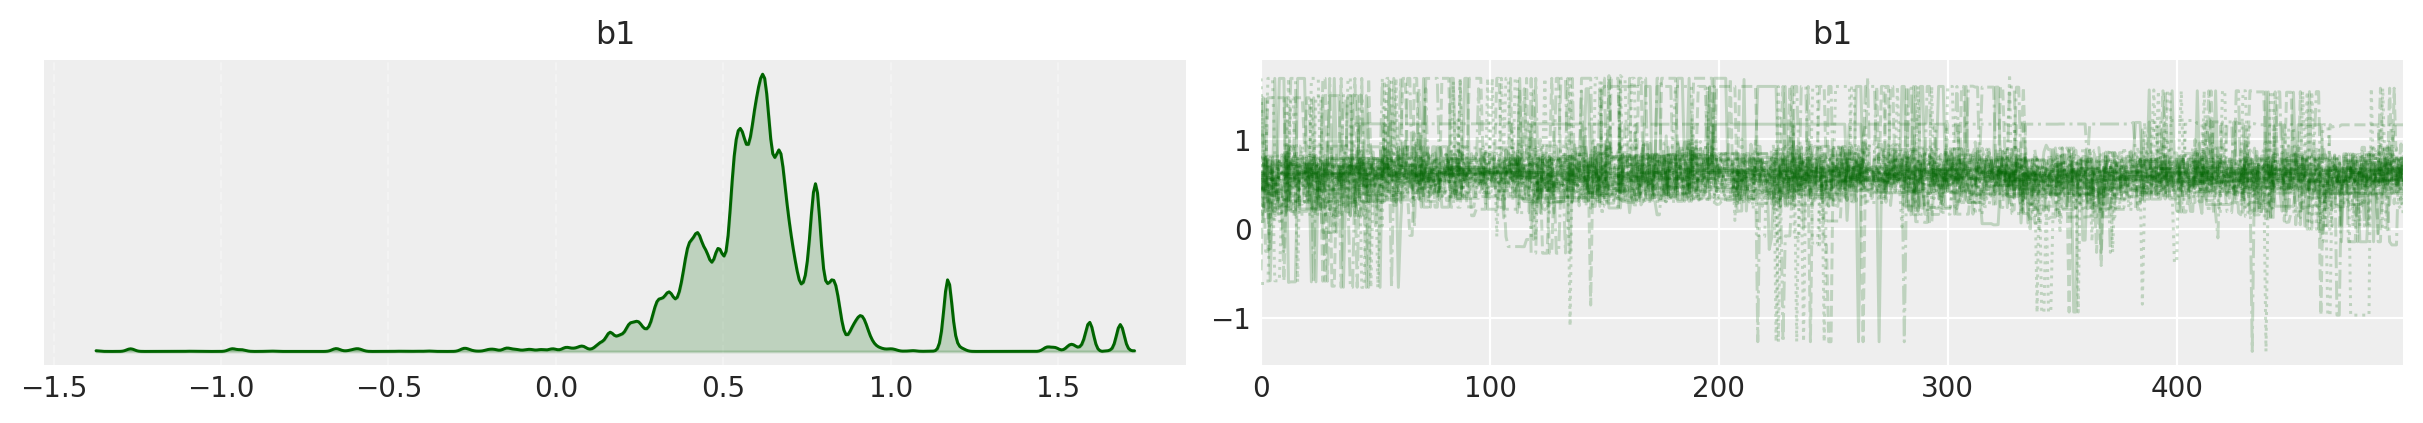

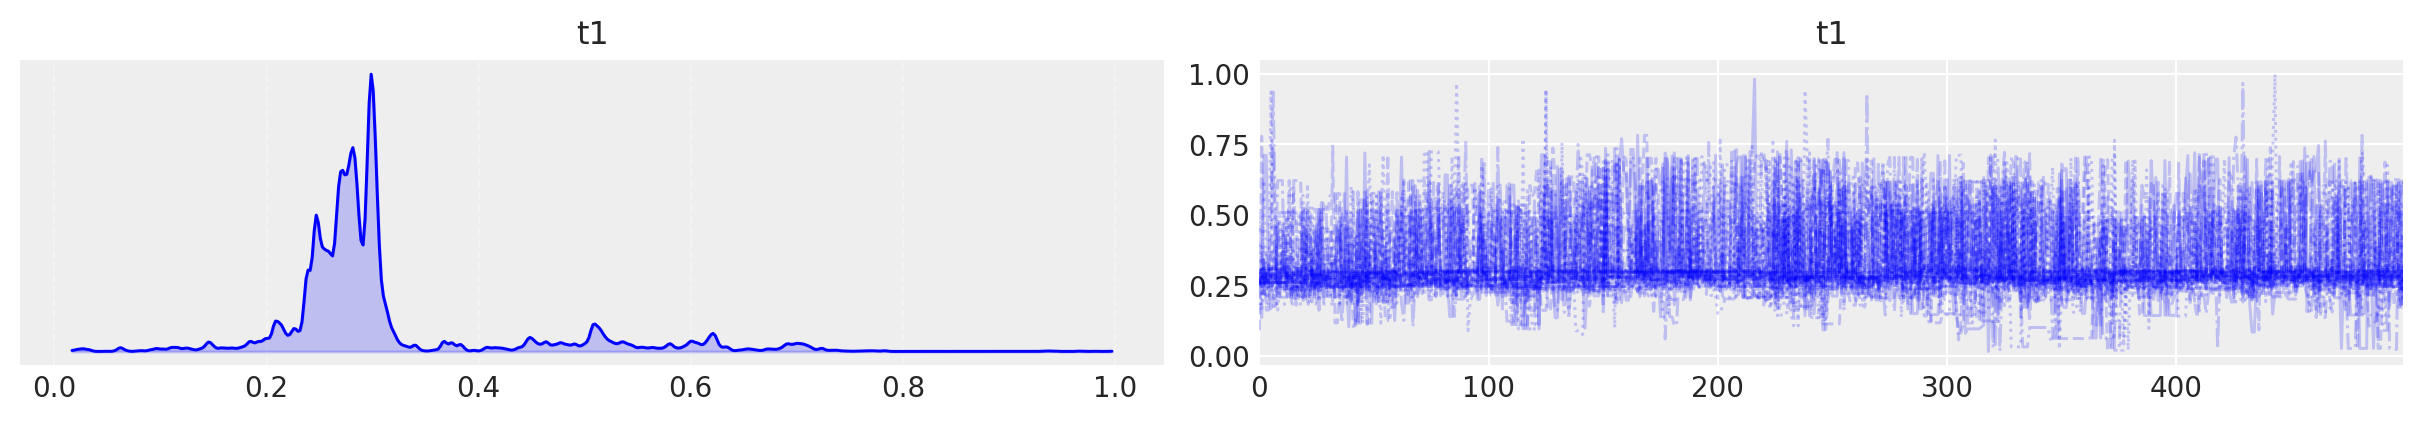

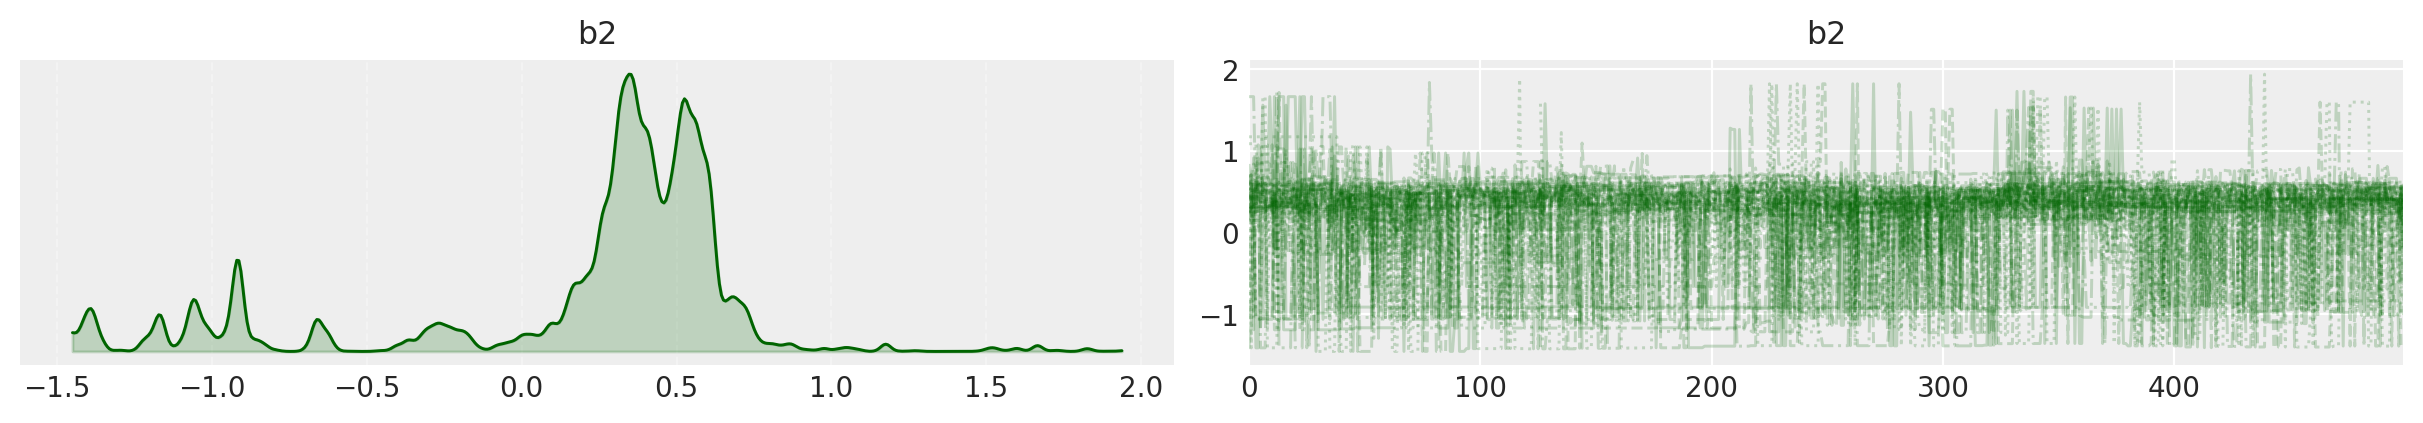

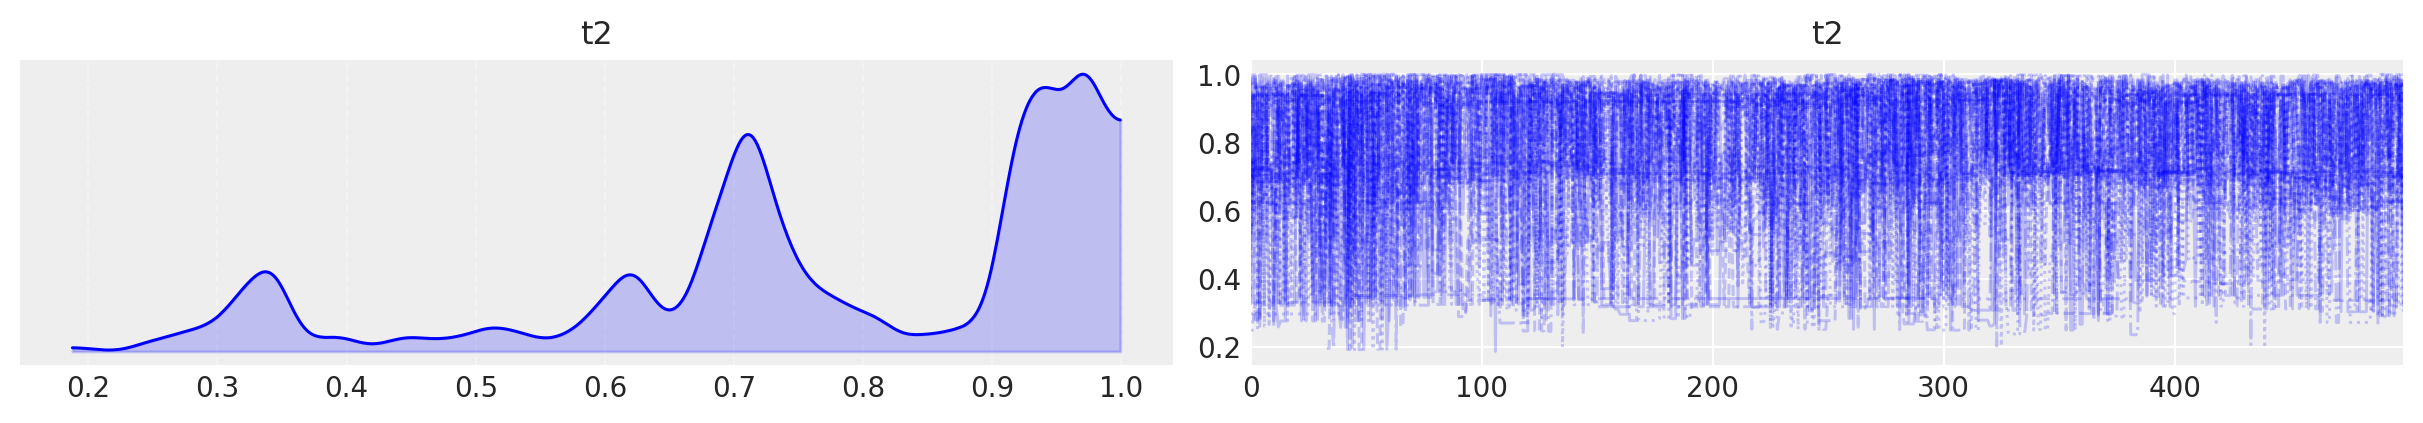

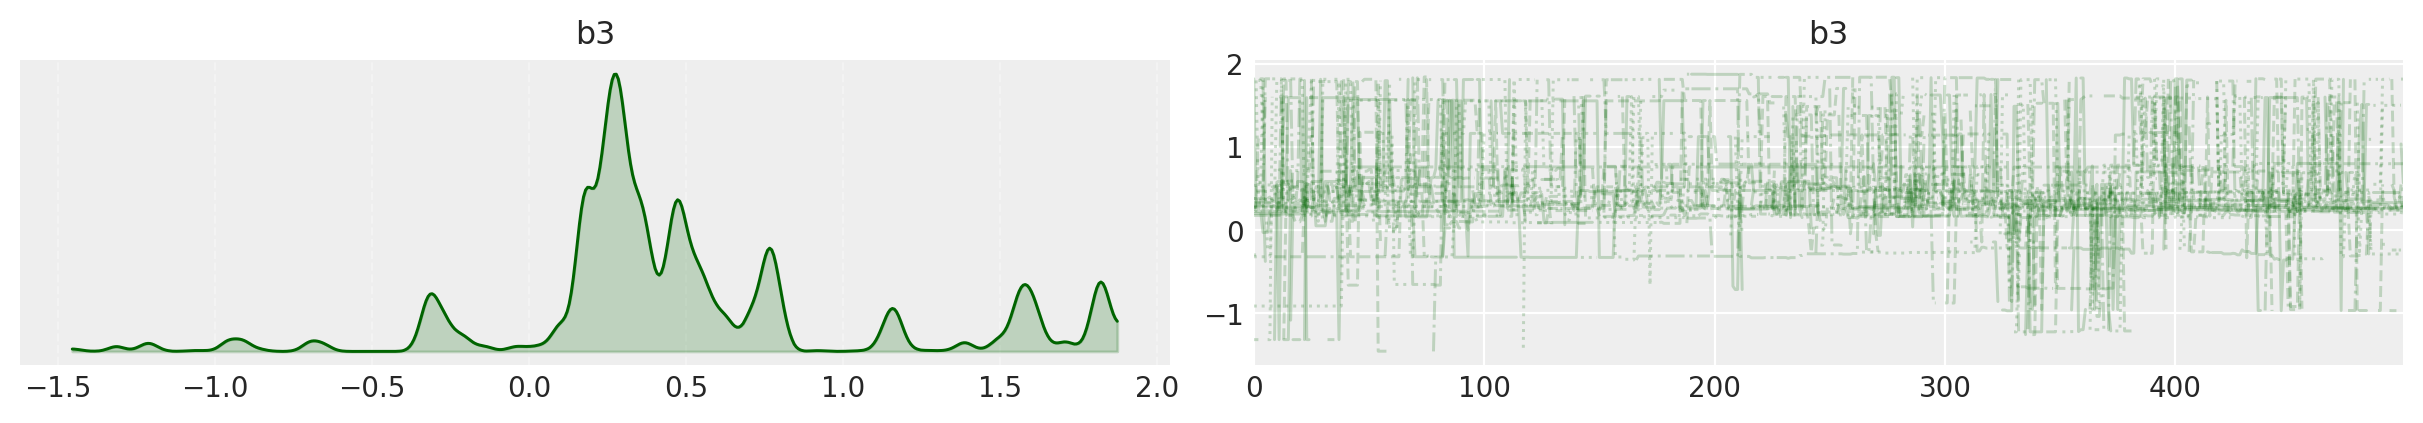

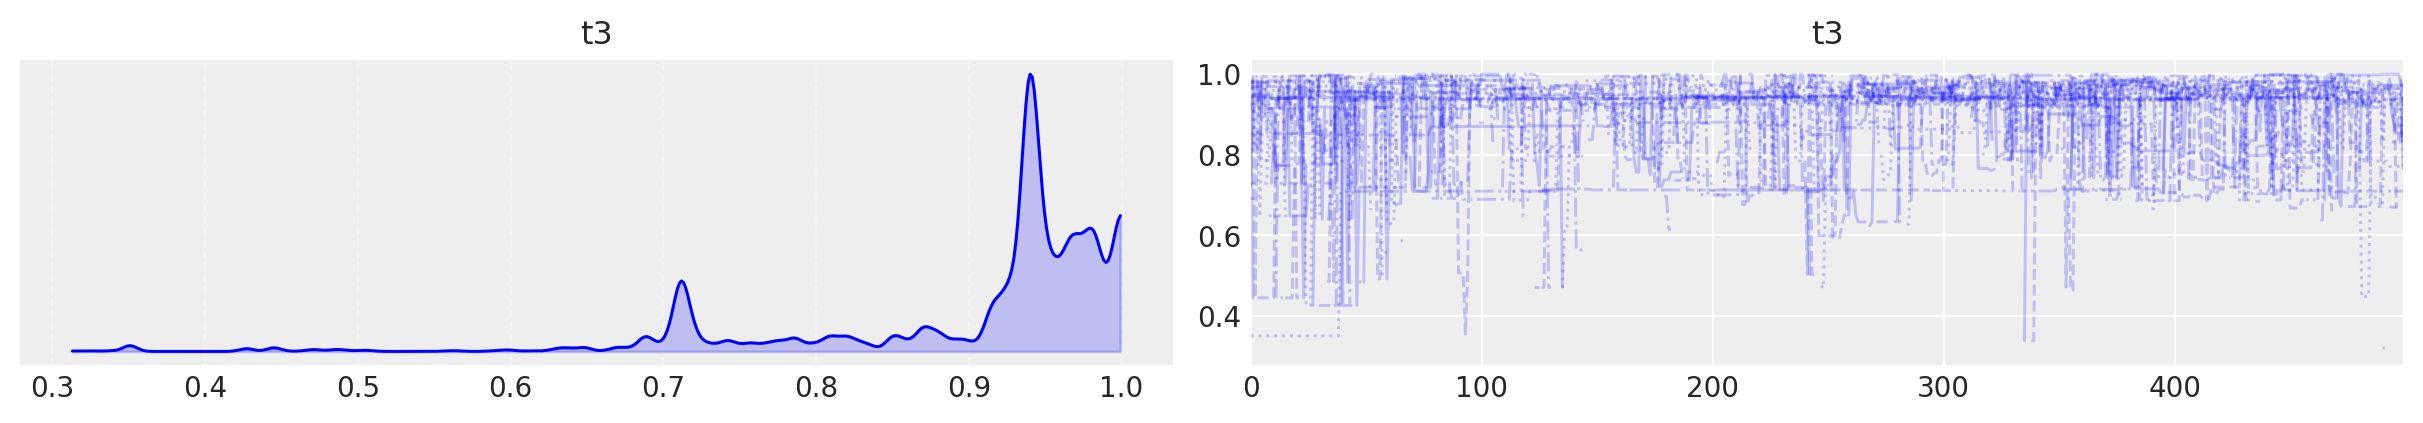

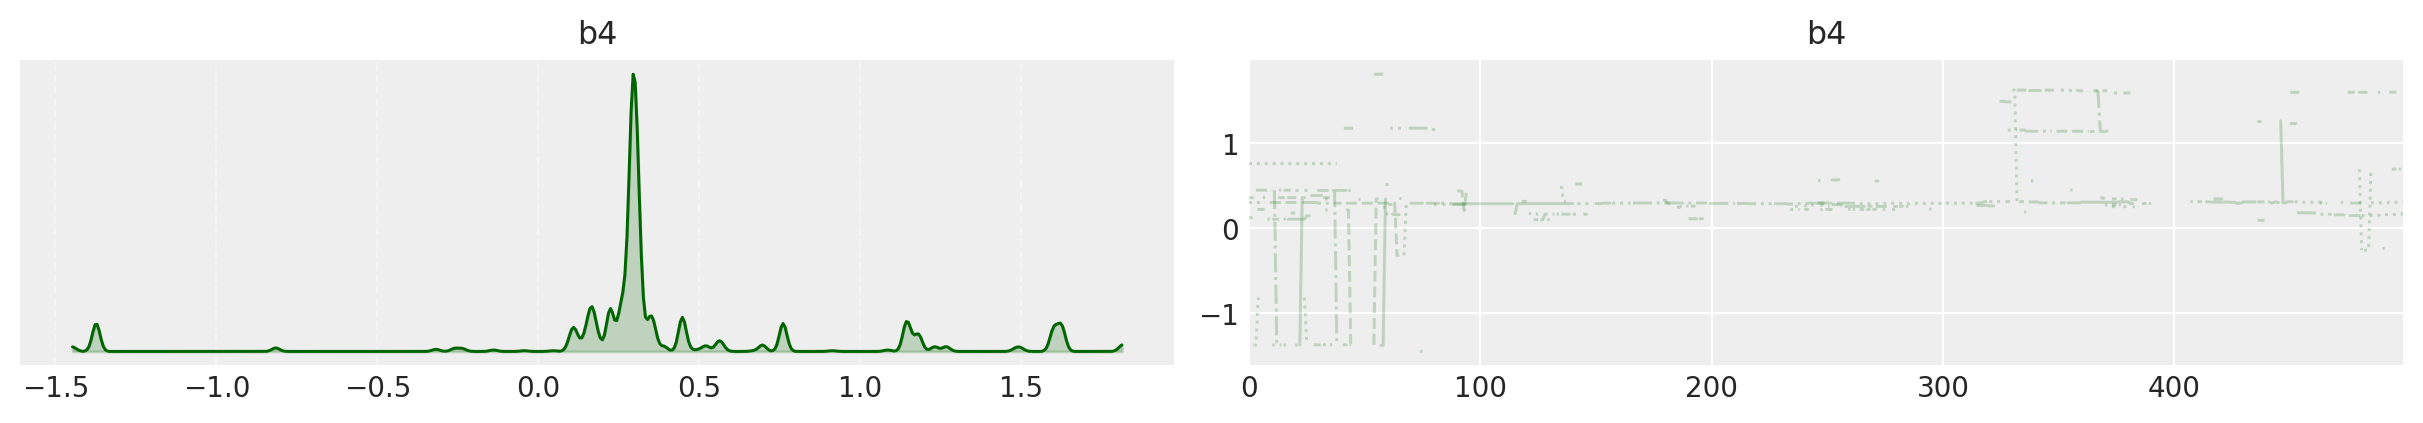

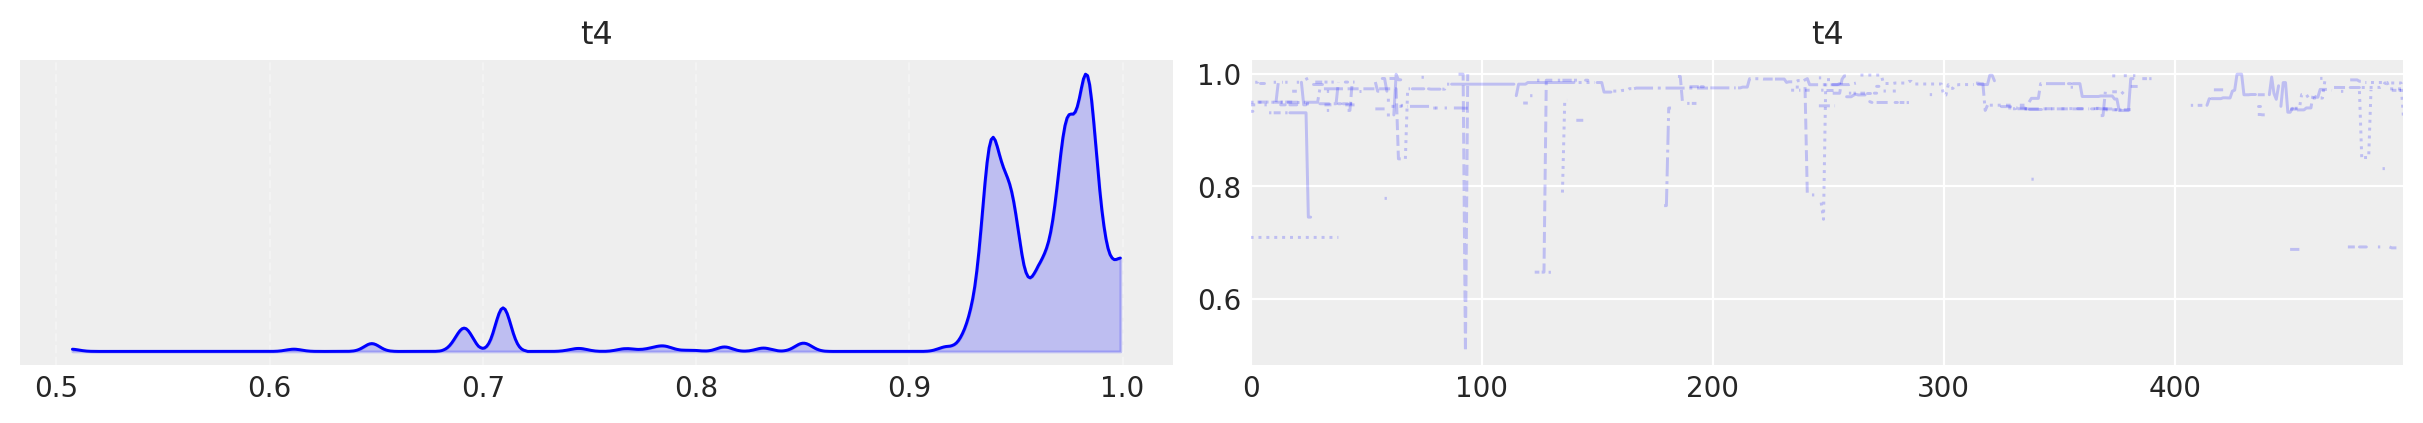

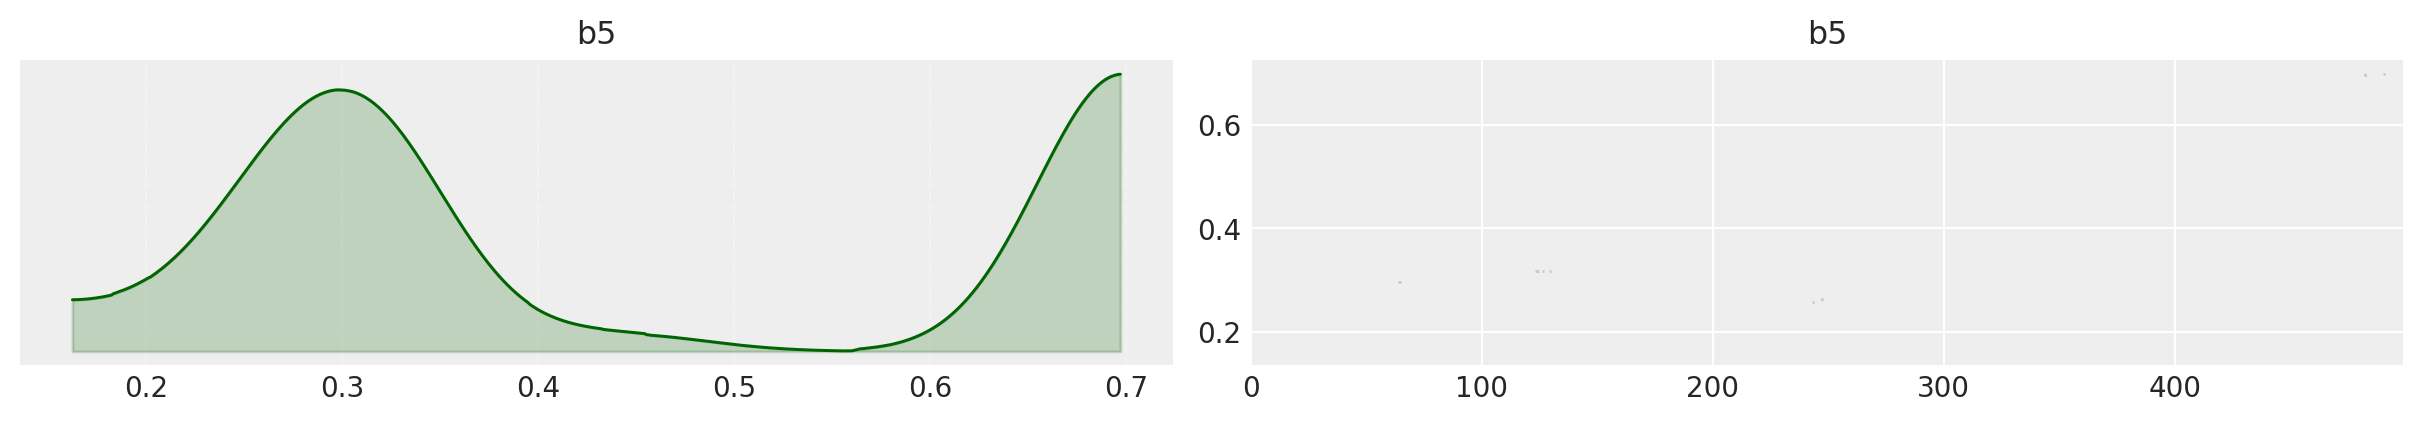

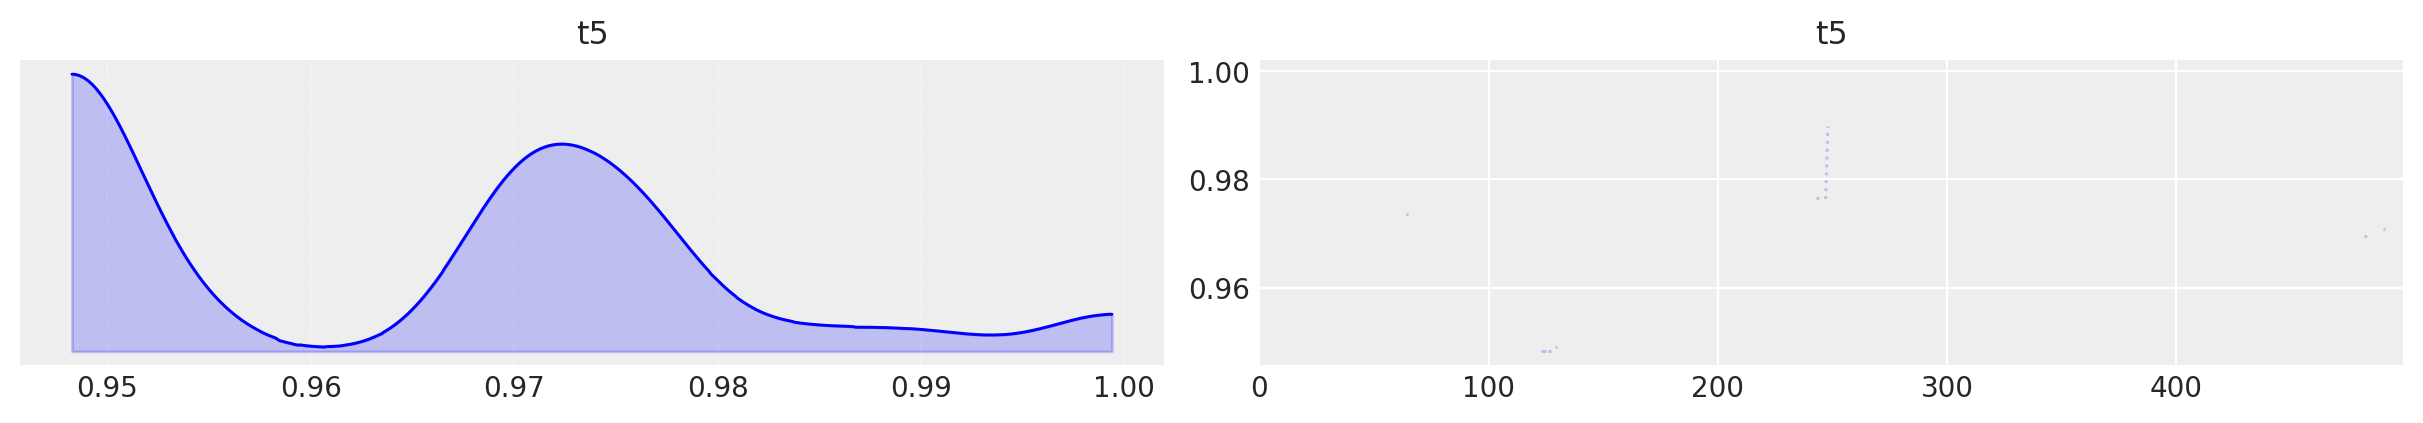

In [1346]:
for component_id in range(nleaves_max["components"]):
    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_beta],
        f"b{component_id + 1}",
        None,
        beta_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[0],
    )
    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_tau],
        f"t{component_id + 1}",
        None,
        tau_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[1],
    )

### Trace plot for $\alpha_0$ and $\sigma^2$ (for all p)

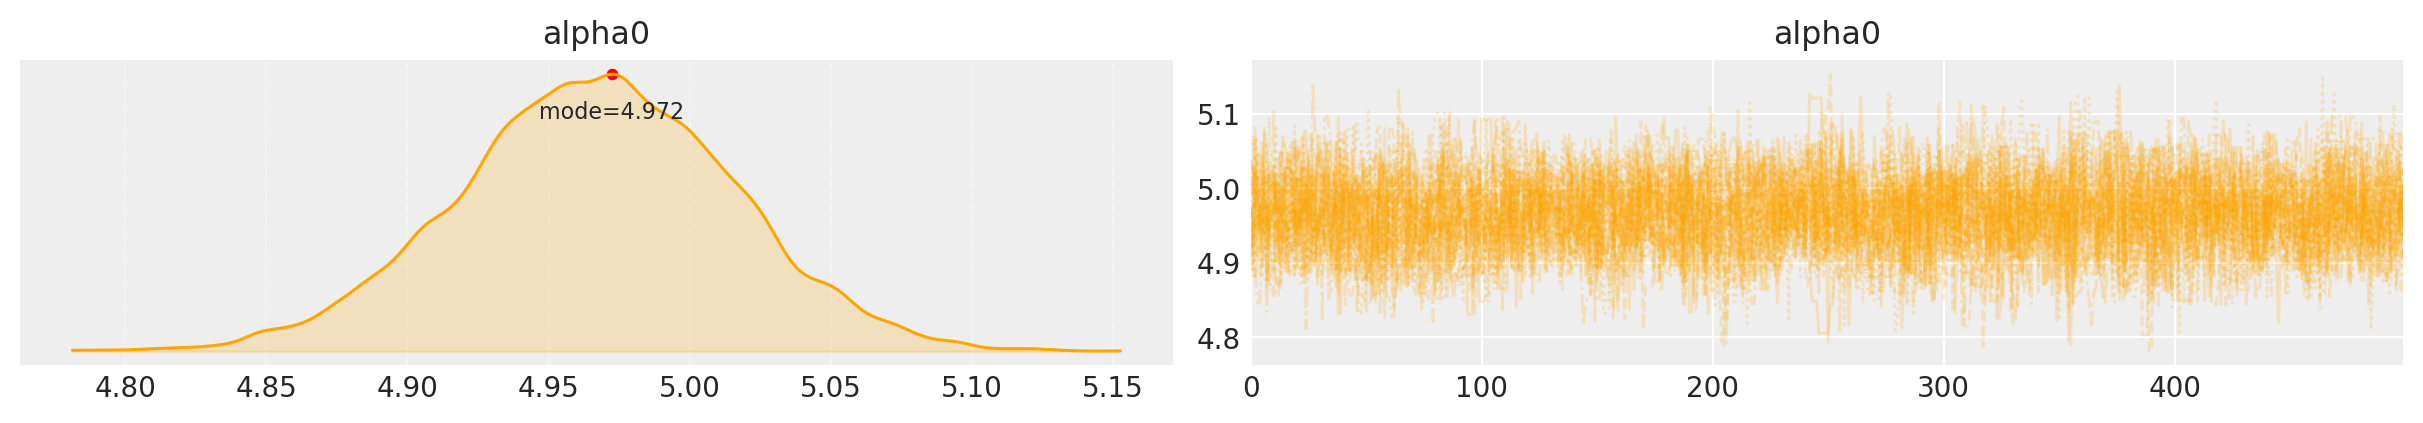

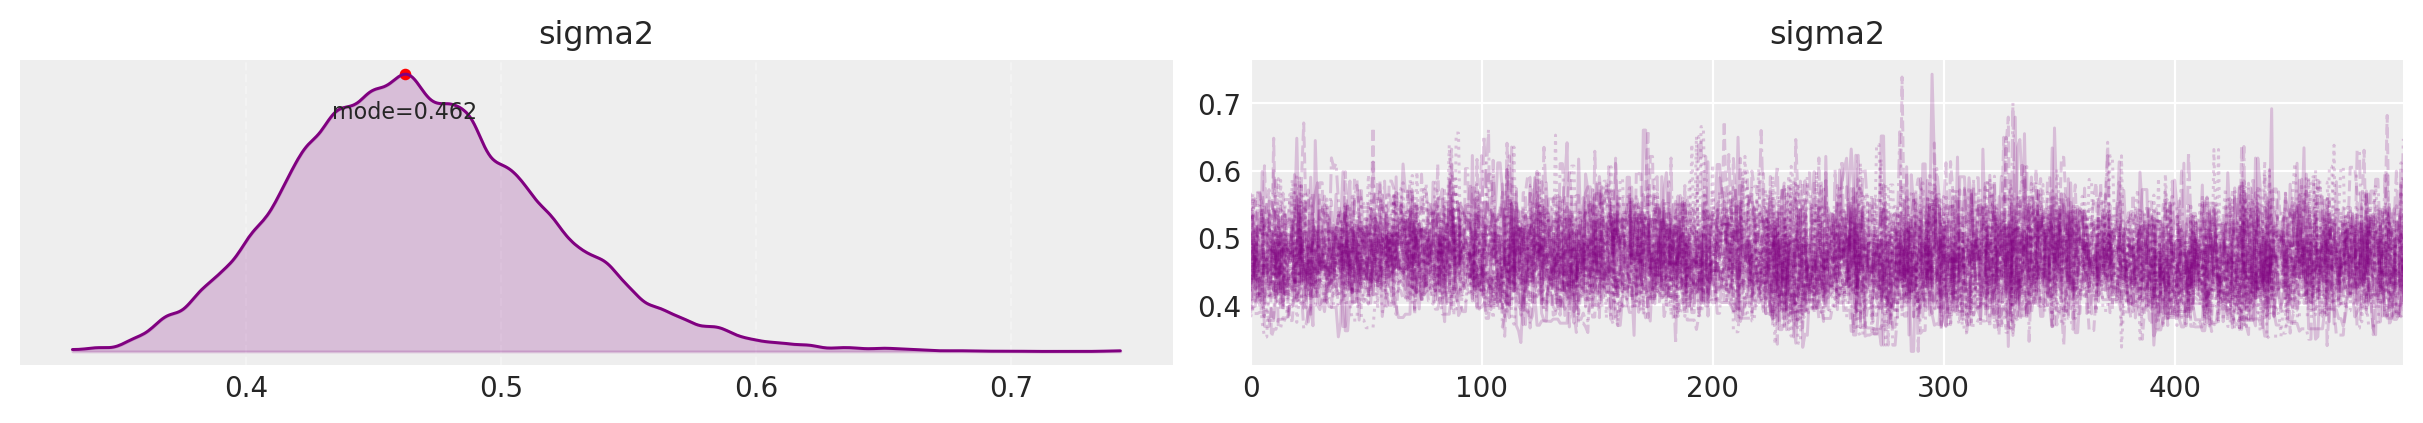

In [1347]:
plot_utils.plot_trace(
    full_chain_common[..., THETA_SPACE.idx_alpha0],
    "alpha0",
    None,
    Y.mean() if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
    mode=True,
    color=COLORS[2],
)
plot_utils.plot_trace(
    full_chain_common[..., THETA_SPACE.idx_sigma2],
    "sigma2",
    None,
    np.var(y[idx_train] - y_noiseless[idx_train])
    if SYNTHETIC_DATA and MODEL_GEN == "RKHS"
    else None,
    mode=True,
    color=COLORS[3],
)

### Trace plot for p

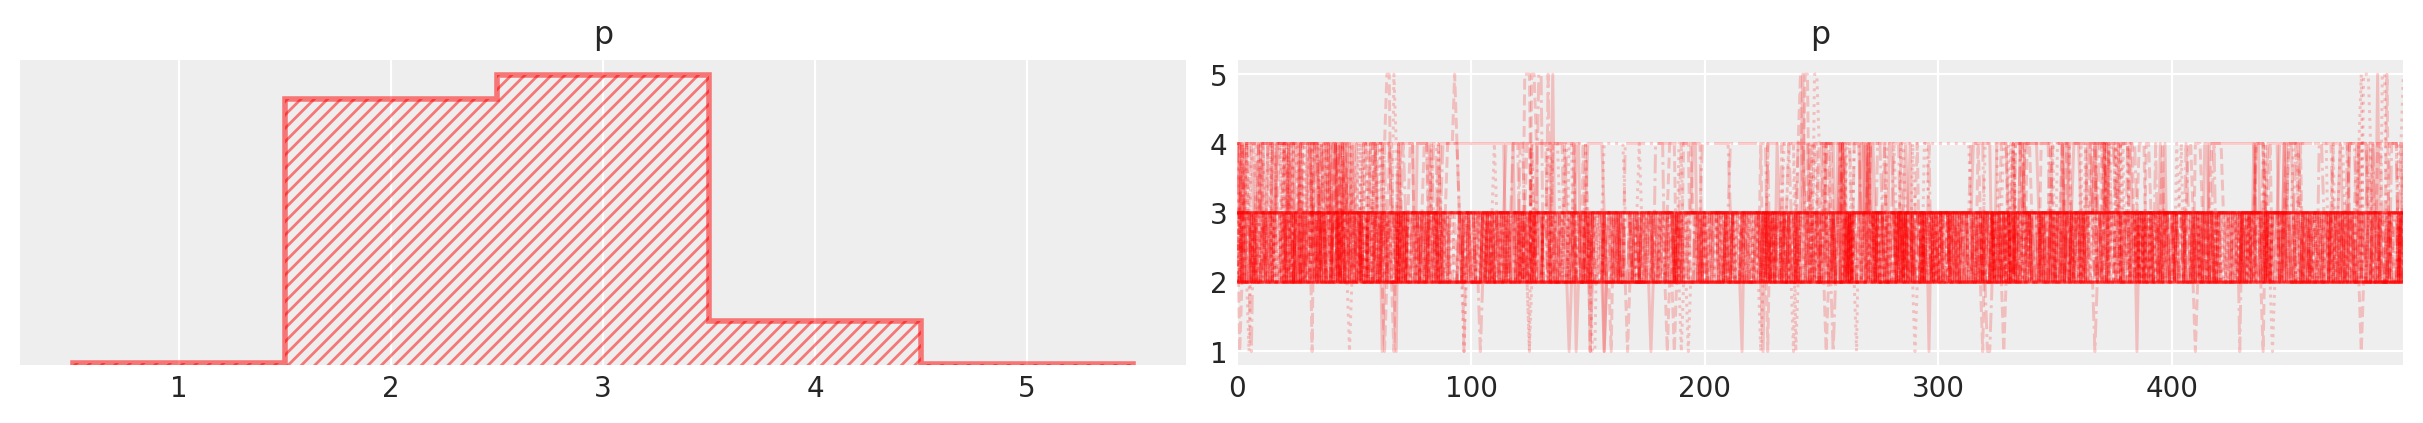

In [1348]:
color = "red"
axs = az.plot_trace(
    nleaves.T,
    combined=True,
    compact=False,
    chain_prop={"linestyle": ("solid", "dotted", "dashed", "dashdot")},
    labeller=MapLabeller({"x": "p"}),
    trace_kwargs={"color": color, "alpha": 0.2},
    hist_kwargs={
        "color": color,
        "lw": 2,
        "alpha": 0.5,
        "histtype": "step",
        "hatch": "/////",
    },
)
axs[0, 1].set_yticks(np.arange(nleaves_max["components"]) + 1)

if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
    axs[0, 0].axvline(
        x=len(beta_true), color=color, linestyle="--", alpha=0.5, label="True value"
    )
    axs[0, 0].legend(fontsize=9)

### Tempered posterior distribution of the number of components (p)

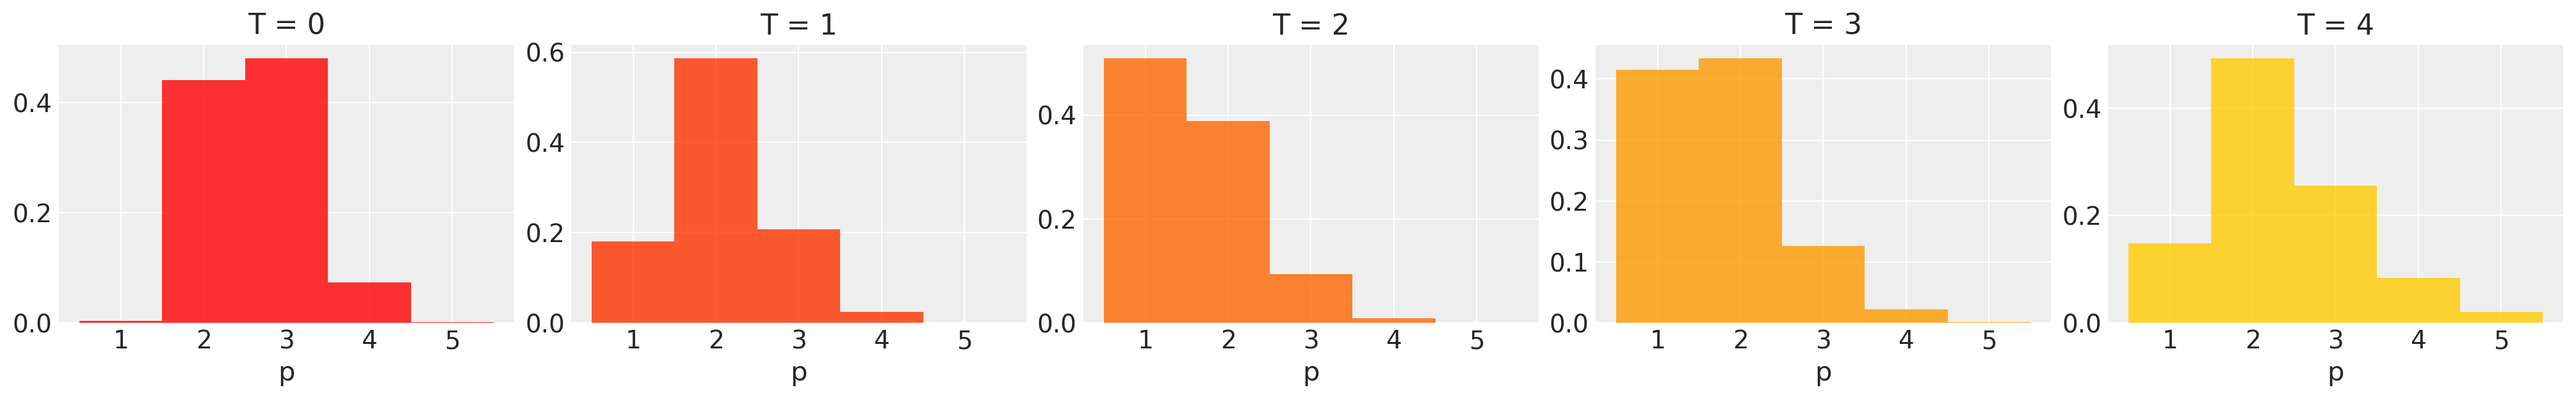

In [1349]:
fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
colors = plt.get_cmap("autumn")
bins = np.arange(1, nleaves_max["components"] + 2) - 0.5

for temp, ax_t in enumerate(ax):
    color = colors(temp / ntemps)
    ax_t.set_title(f"T = {temp}")
    ax_t.set_xlabel("p")
    ax_t.set_xticks(np.arange(nleaves_max["components"] + 1))
    ax_t.hist(
        nleaves_all_T[:, temp].flatten(),
        density=True,
        bins=bins,
        color=color,
        alpha=0.8,
    )

## Prediction

Consider $\theta_p = (b_1,\dots, b_p, t_1,\dots, t_p, \alpha_0, \sigma^2)$ and the linear model $y\equiv F(\theta_p, p|x) = \alpha_0 + \sum_{j=1}^p b_j x(t_j)$. After a RJMCMC run on $D_n = (X,Y)$, we get $M$ samples $\{(\theta_{p_m}^m, p_m)\}$, $m=1,\dots,M$, of the corresponding posterior distribution $\pi(\theta_p, p | D)$ (the samples of all walkers are aggregated together, so $M=\texttt{nsteps}\times \texttt{nwalkers}$). We want to predict the label $y^*$ of a regressor $x^*$, using the RMSE to measure the error on each case.

- **Method 1 (PP)**: Posterior predictive distribution for all $p$. Considering a summary function $g$, such as the mean, trimmed mean (with, say, 10% of values ignored on each side) or median, the predictions are simply $g(\{F(\theta_{p_m}^m, p_m| x^*)\}_m)$. For the mean for example, we get:
$$y^* = \frac{1}{M}\sum_{m=1}^M F(\theta_{p_m}^{m}, p_m | x^*).$$
Since the noise $\sigma^2$ is disregarded in the model $F()$, we are essentially doing an "average of the average", so to speak. The values of $(\sigma^2)^m$ could be used to measure the uncertainty of the predictions.

- **Method 2 (Weighted PP)**: Posterior predictive distribution for all $p$, weighted by the posterior of each p. This is based on the concept of *model averaging*: $\pi(\theta|D) = \sum_p \pi(\theta|D,p)\pi(p|D)$. Denote $M_p = \sum_{m=1}^M \mathbb{I}(p_m = p)$ and the approximation of the posterior distribution of $p$ by $\tilde\pi(p|D) = \frac{1}{M} M_p$. The predictions are:
$$y^* = \sum_{p=1}^P \tilde\pi(p|D) g(\{F(\theta_{p}^m, p | x^*)\}_{m:p_m=p}).$$
Particularizing for the mean, we get the same result as Method 1 above:
$$y^* = \sum_{p=1}^P \tilde\pi(p|D) \frac{1}{M_p}\sum_{m:\ p_m = p} F(\theta_{p}^m, p | x^*) = \frac{1}{M}\sum_{p=1}^P\sum_{m:\ p_m = p} F(\theta_{p}^m, p | x^*) = \frac{1}{M}\sum_{m=1}^M F(\theta_{p_m}^{m}, p_m | x^*).$$

- **Method 3 (MAP PP)**: Same as Method 1, but first condition on the most probable posterior value of $p$, then use the posterior predictive distribution for that value of $p$. Define $\hat p = \max_p M_p$ and compute the predictions as $g(\{F(\theta_{p_m}^m, p_m| x^*)\}_{m:p_m=\hat p})$. For example, for the mean:
$$y^* = \frac{1}{M_{\hat p}}\sum_{m:\ p_m = \hat p} F(\theta_{\hat p}^{m}, \hat p | x^*).$$
If there is more than one mode, always consider the smallest one.

- **Method 4 (Weighted summary)**: Similar to Method 2, but instead of using the PP for predictions, compute a single point summary statistic $T$ of all values in $\theta_p$ for each $p$ (minus the error variance $\sigma^2$), and use them as inputs to $F()$. Consider the mean, trimmed mean, median and mode as summaries. In this case, $T$ plays the part the aggregating function $g()$. The predictions are:
$$y*= \sum_{p=1}^P \tilde\pi(p|D) F(T\{\theta_p^m\}_{m:p_m=p}, p|x*)$$
Note that in this case the parameter $\sigma^2$ is treated as a nuisance parameter and thus ignored in the final predictions.

- **Method 5 (MAP summary)**: Same as Method 3, but compute a summary of each value of $\theta_{\hat p}$ and use them as inputs to $F()$.

- **Method 6 (Weighted variable selection)**: Same as Method 4, but instead of using the summaries of $\theta$ as input to $F()$, use *only* the summaries of $t$ to reduce the original dataset to a finite-dimensional one (for each $p$). Then apply a finite-dimensional regression method for each of the $p$ reduced data sets, and combine the responses by the weight of the posterior of $p$.
  
- **Method 7 (MAP variable selection)**: Same as Method 5, but instead of using the summaries of $\theta$ as input to $F()$, use them to reduce the original dataset to a finite-dimensional one with $\hat p$ features. Then apply a finite-dimensional regression method.

In [1350]:
FIT_SK = True
RUN_SUMMARY_METHODS = False

SUMMARY_STATISTICS = [
    np.mean,
    lambda x, axis: trim_mean(x, 0.1),
    np.median,
    lambda x, axis: np.apply_along_axis(utility.mode_kde, axis=axis, arr=x),
]

DF_COLUMNS = ["Estimator", "Features", "Noise", "RMSE", "rRMSE"]
SORT_BY = -2
FOLDS = KFold(n_splits=5, shuffle=True, random_state=SEED)

max_used_p = np.max(np.unique(nleaves))

### Reference methods

In [1351]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_components = np.arange(nleaves_max["components"]) + 1
n_basis_bsplines = n_components[n_components >= 4]  # Cubic splines, so n_basis must be >= 4
n_basis_fourier = n_components[n_components % 2 != 0]

basis_bspline = [BSplineBasis(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [FourierBasis(n_basis=p) for p in n_basis_fourier]
params_regularizer = {"reg__alpha": alphas}
params_select = {"selector__p": n_components}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}

regressors = run_utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_basis,
    params_pls,
    random_state=SEED,
)

In [1352]:
# -- Fit reference models and show metrics

if FIT_SK:
    df_reference, reg_cv = run_utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        FOLDS,
        kind="linear",
        n_jobs=-1,
        sort_by=SORT_BY,
        verbose=False,
    )
    print("-- All methods --")
    display(
        df_reference.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [1353]:
if FIT_SK:
    df_reference_one = df_reference[~df_reference["Estimator"].str.contains("\\+")]
    print("-- One-stage methods --")
    display(df_reference_one.style.apply(lambda x: utility.color_reference_methods(x, df_reference_one)).hide(axis="index"))
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [1354]:
if FIT_SK:
    df_reference_two = df_reference[df_reference["Estimator"].str.contains("\\+")]
    print("-- Two-stage methods --")
    display(df_reference_two.style.apply(lambda x: utility.color_reference_methods(x, df_reference_two)).hide(axis="index"))
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Method 1 (PP)

In [1355]:
np.random.seed(SEED)

noises = [True, False]
names = ["pp_mean", "pp_tmean", "pp_median", "pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_pp(
        full_chain_components,
        full_chain_common,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    # Compute rmse
    rmse = root_mean_squared_error(Y_test, Y_pred)

    df.loc[len(df)] = [
        name,
        max_used_p,
        noise,
        rmse,
        rmse / np.std(Y_test),
    ]

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = df.copy()
df.style.hide(axis="index")

### Method 2 (Weighted PP)

In [1356]:
np.random.seed(SEED)

noises = [True, False]
names = ["w_pp_mean", "w_pp_tmean", "w_pp_median", "w_pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_weighted_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    # Compute rmse
    rmse = root_mean_squared_error(Y_test, Y_pred)

    df.loc[len(df)] = [
        name,
        max_used_p,
        noise,
        rmse,
        rmse / np.std(Y_test),
    ]

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 3 (MAP PP)

In [1357]:
np.random.seed(SEED)

noises = [True, False]
names = ["map_pp_mean", "map_pp_tmean", "map_pp_median", "map_pp_mode"]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_map_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
    )

    # Compute rmse
    rmse = root_mean_squared_error(Y_test, Y_pred)

    df.loc[len(df)] = [name, map_p, noise, rmse, rmse / np.std(Y_test)]

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 4 (Weighted summary)

In [1358]:
if RUN_SUMMARY_METHODS:
    np.random.seed(SEED)
    
    names = ["mean", "tmean", "median", "mode"]
    df = pd.DataFrame(columns=DF_COLUMNS)
    
    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_weighted_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            THETA_SPACE,
            X_test,
            summary_statistic,
        )
    
        # Compute rmse
        rmse = root_mean_squared_error(Y_test, Y_pred)
    
        df.loc[len(df)] = [
            "w_summary_" + name,
            max_used_p,
            "N/A",
            rmse,
            rmse / np.std(Y_test),
        ]
    
    df.sort_values(df.columns[SORT_BY], inplace=True)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 5 (MAP summary)

In [1359]:
if RUN_SUMMARY_METHODS:
    np.random.seed(SEED)
    
    names = ["mean", "tmean", "median", "mode"]
    map_p = mode_discrete(nleaves, axis=None).mode
    df = pd.DataFrame(columns=DF_COLUMNS)

    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_map_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            map_p,
            THETA_SPACE,
            X_test,
            summary_statistic,
        )
    
        # Compute rmse
        rmse = root_mean_squared_error(Y_test, Y_pred)
    
        df.loc[len(df)] = [
            "map_summary_" + name,
            map_p,
            "N/A",
            rmse,
            rmse / np.std(Y_test),
        ]
    
    df.sort_values(df.columns[SORT_BY], inplace=True)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 6 (Weighted variable selection)

In [1360]:
np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"reg__alpha": np.logspace(-4, 4, 20)}
regs = [
    (
        "ridge",
        GridSearchCV(
            Pipeline([("reg", Ridge(random_state=SEED))]),
            params_regularizer,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (reg_name, reg) in product(
    zip(names, SUMMARY_STATISTICS), regs
):
    Y_pred = prediction.predict_weighted_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        reg,
    )

    # Compute rmse
    rmse = root_mean_squared_error(Y_test, Y_pred)

    df.loc[len(df)] = [
        "w_vs_" + summary_name + "+" + reg_name,
        max_used_p,
        "N/A",
        rmse,
        rmse / np.std(Y_test),
    ]

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 7 (MAP variable selection)

In [1361]:
np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"reg__alpha": np.logspace(-4, 4, 20)}
regs = [
    (
        "ridge",
        GridSearchCV(
            Pipeline([("reg", Ridge(random_state=SEED))]),
            params_regularizer,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (reg_name, reg) in product(
    zip(names, SUMMARY_STATISTICS), regs
):
    Y_pred = prediction.predict_map_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        reg,
    )

    # Compute rmse
    rmse = root_mean_squared_error(Y_test, Y_pred)

    df.loc[len(df)] = [
        "map_vs_" + summary_name + "+" + reg_name,
        map_p,
        "N/A",
        rmse,
        rmse / np.std(Y_test),
    ]

df.sort_values(df.columns[SORT_BY], inplace=True)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

## Prediction results analysis

### Comparison of all RKHS methods

In [1362]:
df_all_methods.sort_values(df_all_methods.columns[SORT_BY], inplace=True)
df_all_methods.drop_duplicates(inplace=True)
df_all_methods.style.hide(axis="index")

In [1363]:
print("-- One-stage methods --")
df_all_methods_one = df_all_methods[~df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_one.style.hide(axis="index")

-- One-stage methods --


In [1364]:
print("-- Two-stage methods --")
df_all_methods_two = df_all_methods[df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_two.style.hide(axis="index")

-- Two-stage methods --


### Comparison with reference methods

In [1365]:
if FIT_SK:
    df_comparison_all = pd.concat([df_all_methods, df_reference], ignore_index=True)
    df_comparison_all.sort_values(df_comparison_all.columns[SORT_BY], inplace=True)
    df_comparison_all = df_comparison_all.drop_duplicates().fillna("N/A")
    print("-- All methods --")
    display(
        df_comparison_all.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [1366]:
if FIT_SK:
    print("-- One-stage methods --")
    df_comparison_all_one = df_comparison_all[
        ~df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_one.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [1367]:
if FIT_SK:
    print("-- Two-stage methods --")
    df_comparison_all_two = df_comparison_all[
        df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_two.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Visual comparison with reference methods

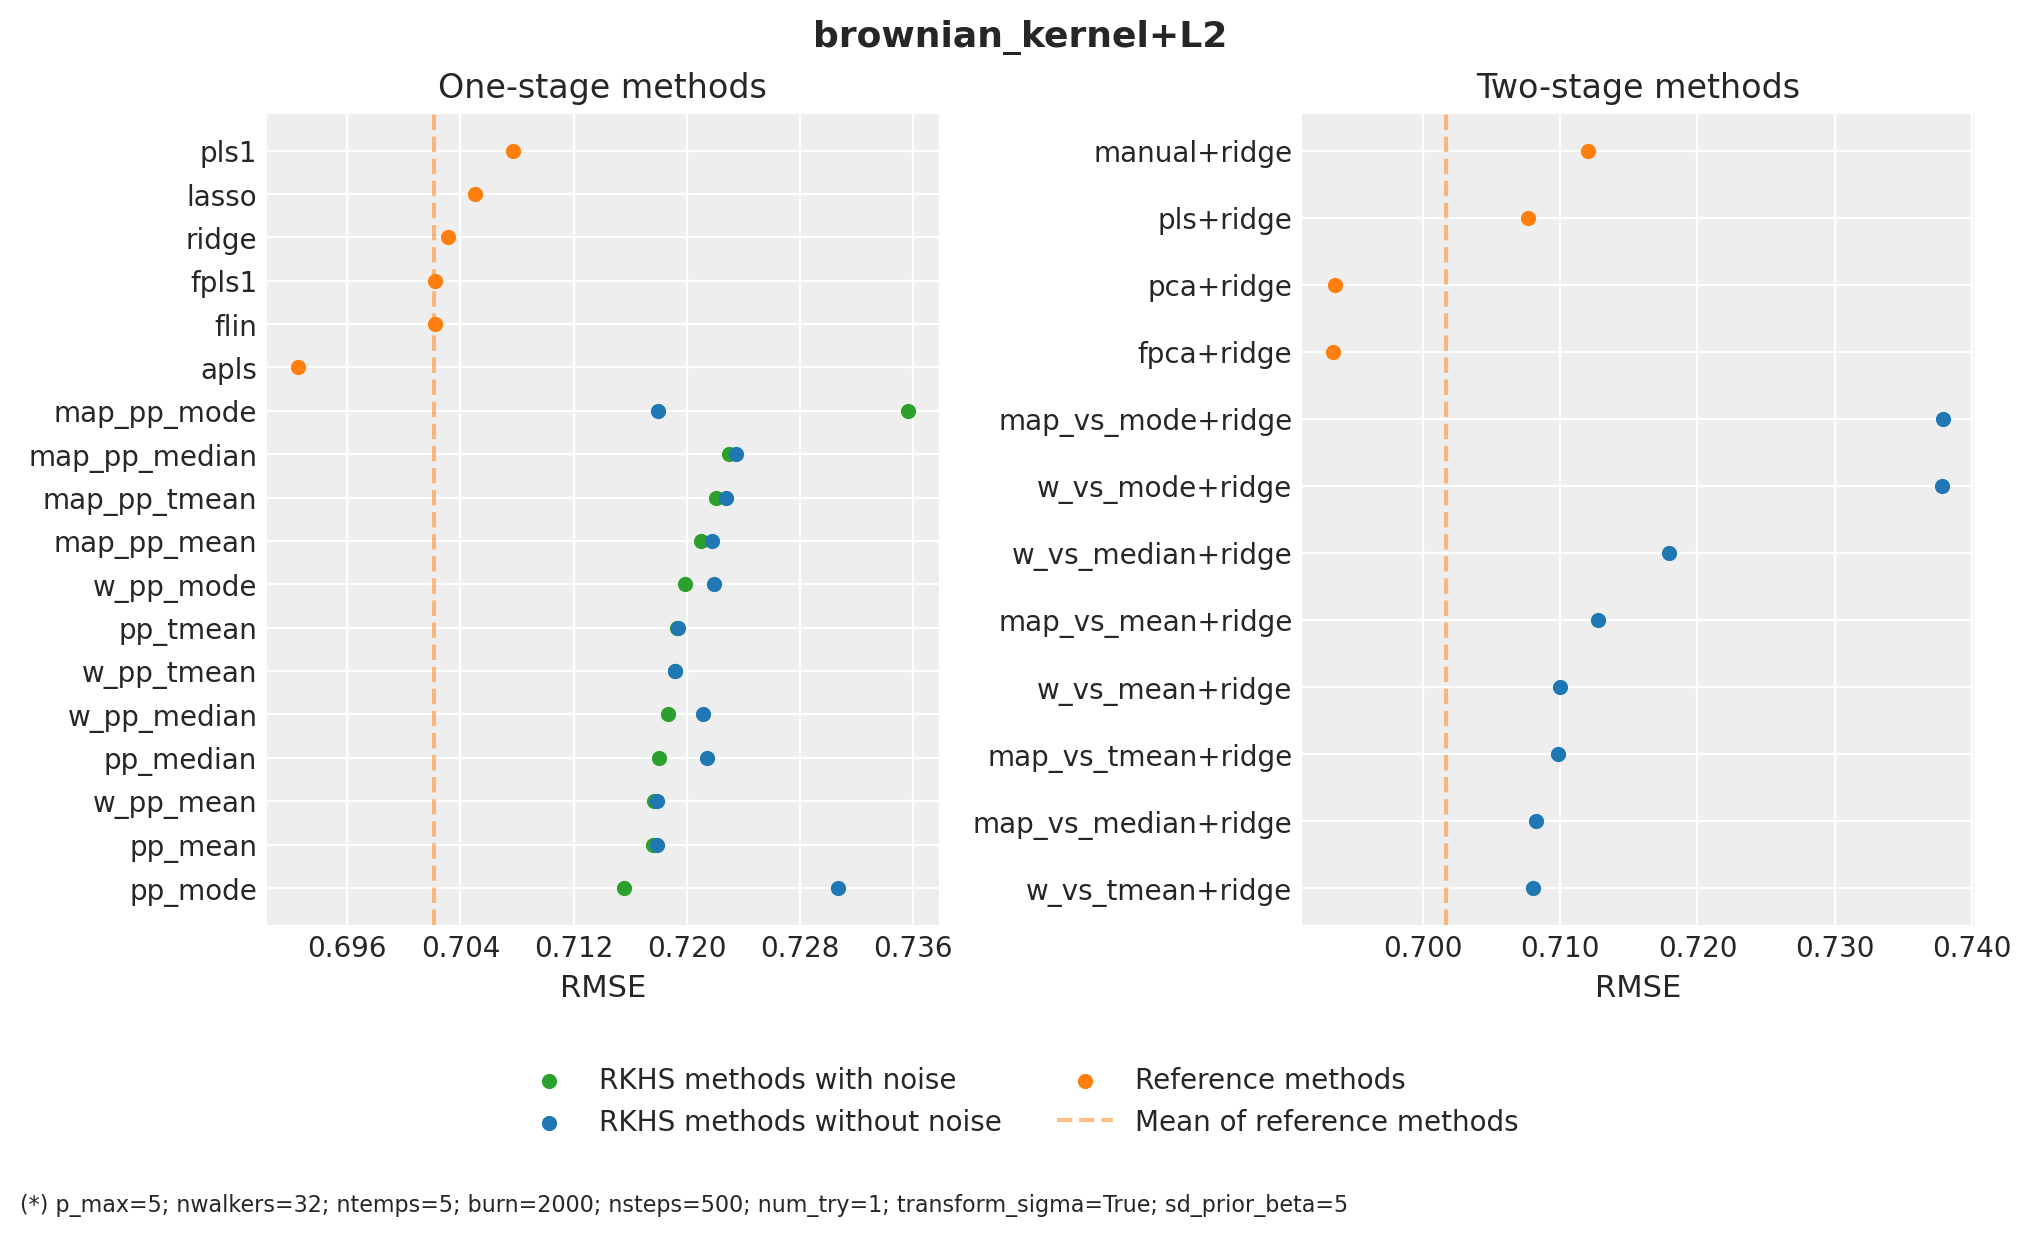

In [1368]:
SAVE_FIG = False

df_all_methods_one_noise = df_all_methods_one[df_all_methods_one["Noise"] == True]
df_all_methods_one_noiseless = df_all_methods_one[
    ~(df_all_methods_one["Noise"] == True)
]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(
    df_all_methods_one_noise["RMSE"],
    df_all_methods_one_noise["Estimator"],
    color="tab:green",
    label="RKHS methods with noise",
    s=20,
)
axs[0].scatter(
    df_all_methods_one_noiseless["RMSE"],
    df_all_methods_one_noiseless["Estimator"],
    color="tab:blue",
    label="RKHS methods without noise",
    s=20,
)
axs[1].scatter(
    df_all_methods_two["RMSE"], df_all_methods_two["Estimator"], color="tab:blue", s=20
)
if FIT_SK:
    axs[0].scatter(
        df_reference_one["RMSE"],
        df_reference_one["Estimator"],
        color="tab:orange",
        label="Reference methods",
        s=20,
    )
    axs[0].axvline(
        np.mean(df_reference_one["RMSE"]),
        linestyle="--",
        color="tab:orange",
        label="Mean of reference methods",
        alpha=0.5,
    )
    axs[1].scatter(
        df_reference_two["RMSE"],
        df_reference_two["Estimator"],
        color="tab:orange",
        s=20,
    )
    axs[1].axvline(
        np.mean(df_reference_two["RMSE"]),
        linestyle="--",
        color="tab:orange",
        alpha=0.5,
    )

for ax in axs:
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    ax.set_xlabel("RMSE", fontsize=11)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%0.3f"))

axs[0].set_title("One-stage methods", fontsize=12)
axs[1].set_title("Two-stage methods", fontsize=12)
if SYNTHETIC_DATA:
    data_gen_name = kernel_fn.__name__ if REGRESSOR_GEN == "GP" else "GBM"
    plt.suptitle(f"{data_gen_name}+{MODEL_GEN}", fontsize=13, fontweight="semibold")
else:
    plt.suptitle(f"{REAL_DATA}", fontsize=13, fontweight="semibold")
fig.legend(
    *axs[0].get_legend_handles_labels(),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    fontsize=10,
    ncol=2,
)
_ = fig.text(
    0,
    -0.2,
    f"(*) p_max={nleaves_max['components']}; nwalkers={nwalkers}; ntemps={ntemps}; "
    f"burn={burn}; nsteps={nsteps}; num_try={num_try if USE_MT_RJ else 1}; transform_sigma={TRANSFORM_SIGMA}; "
    f"sd_prior_beta={SD_PRIOR_BETA}",
    ha="left",
    fontsize=8,
)

if SAVE_FIG:
    import datetime
    fig.savefig(f"results/figures/{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.pdf", bbox_inches='tight')

## Save data

In [1369]:
SAVE_ENSEMBLE_TO_FILE = False
if SAVE_ENSEMBLE_TO_FILE:
    import dill
    if SYNTHETIC_DATA:
        data_gen_name = kernel_fn.__name__ if REGRESSOR_GEN == "GP" else "GBM"
        save_name = f"{data_gen_name}+{MODEL_GEN}"
    else:
        save_name = f"{REAL_DATA}"
    
    with open(f"results/{save_name}.dill", 'wb') as file:
        dill_ensemble = dill.dumps(ensemble)
        file.write(dill_ensemble)

#with open(f"results/{save_name}.dill", 'rb') as file:
#    ensemble_loaded = dill.load(file)

## Notebook metadata

In [1370]:
%watermark -n -u -v -iv -w

Last updated: Mon Apr 22 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

pandas    : 2.1.4
matplotlib: 3.8.2
arviz     : 0.17.0
numpy     : 1.23.5

Watermark: 2.4.3

